### Importing library and data

In [2]:
import pandas as pd
import numpy as np
import re

import gensim
from gensim.utils import simple_preprocess

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.phrases import Phrases, Phraser

import multiprocessing
import docx2txt

from gensim.models import Word2Vec
from afinn import Afinn

In [2]:
mbti = pd.read_csv("MBTI.csv")

In [30]:
sentences = mbti['Bigram'].astype(str).apply(lambda x: x.split())

### W2V - Similarity Scoring, TSNE Clustering Plots

In [32]:
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=10,
                     window=3,
                     size=15,
                     sample=6e-5, 
                     alpha=0.05, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [33]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [34]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=40, report_delay=1)

(55869233, 100426040)

In [35]:
w2v_model.wv.most_similar(positive=["enfp"])

[('infp', 0.9784414768218994),
 ('esfp', 0.9587852358818054),
 ('isfj', 0.9549990892410278),
 ('infj', 0.9540441036224365),
 ('istp', 0.9518377184867859),
 ('enfj', 0.9468611478805542),
 ('isfp', 0.9343791007995605),
 ('isfj_boyfriend', 0.9240228533744812),
 ('istj', 0.9220923185348511),
 ('estp', 0.9193403720855713)]

In [36]:
w2v_model.wv.most_similar(positive=["infp"])

[('enfp', 0.9784414768218994),
 ('infj', 0.9740133285522461),
 ('isfp', 0.9661026000976562),
 ('istp', 0.9637289047241211),
 ('esfp', 0.9605919122695923),
 ('isfj', 0.9532610774040222),
 ('intp', 0.9458476305007935),
 ('istj', 0.9427684545516968),
 ('intj', 0.9373683333396912),
 ('enfj', 0.9338523745536804)]

In [37]:
w2v_model.wv.doesnt_match(['enfp', 'infp', 'istj'])

C:\Users\valli\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'istj'

In [38]:
vocabs = []
vecs = []
for word in w2v_model.wv.vocab:
    vocabs.append(word)
    vecs.append(w2v_model[word])

<ipython-input-38-60a74ab65d4f>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vecs.append(w2v_model[word])


In [39]:
from sklearn.manifold import TSNE
sub_vecs = vecs[:100]
sub_vocab = vocabs[:100]
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2000, random_state=23)
new_values = tsne_model.fit_transform(sub_vecs)

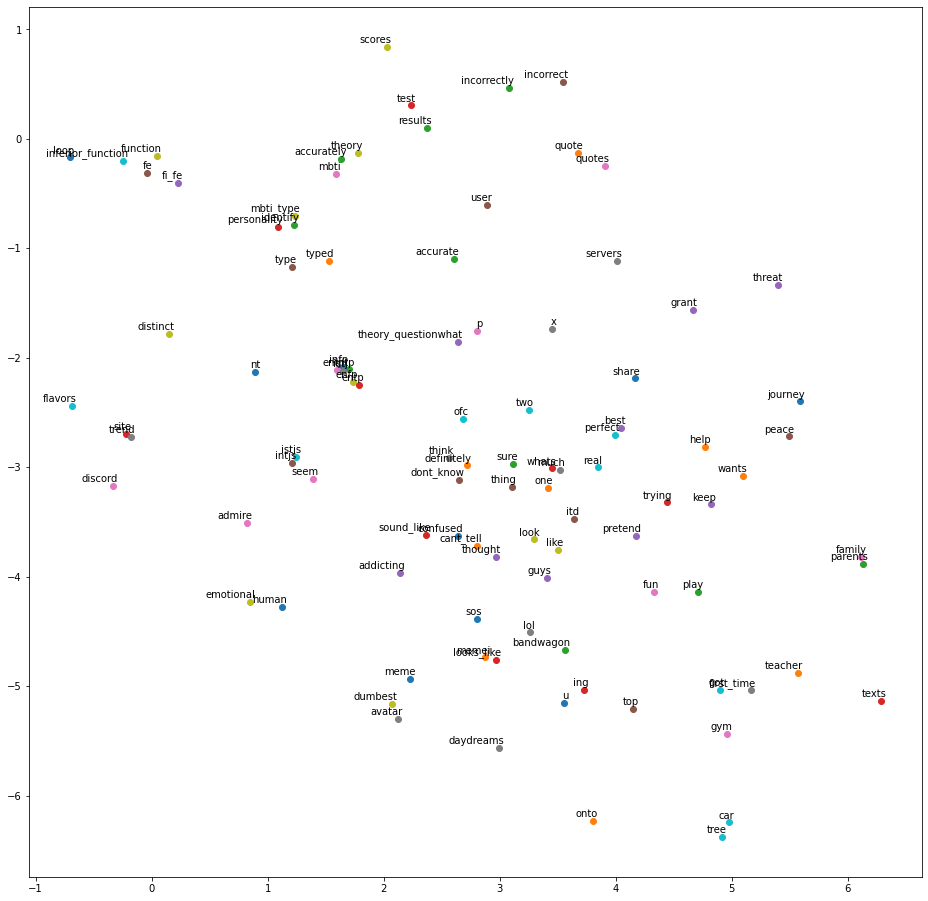

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(sub_vocab[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

### Afinn Score - Heatmap

In [42]:
afinn = Afinn()

In [43]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 100)

<ipython-input-43-2a3bc55e9406>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [44]:
afinn_scores = [afinn.score(text) for text in mbti.Cleaned_Text.astype(str)]

In [45]:
mbti['afinn'] = afinn_scores
mbti[['Tag', 'afinn', 'Cleaned_Text']].head(10)

,Tag,afinn,Cleaned_Text
0,INFP,0.0,meme <3
1,ENFJ,2.0,memeincorrect quote sure trying keep peace family
2,INTP,0.0,memeenfp avatar
3,ENTP,0.0,memefour distinct flavors nt
4,INTJ,0.0,stereotypesinfp
5,ENTP,0.0,advicesupportplease
6,ENTP,2.0,memethis definitely intp looks like
7,ISFJ,3.0,theory questionwhat type admire
8,ISTJ,0.0,memeistj x enfp real
9,INFP,-1.0,memewhen infp wants play entp wants pretend dont know :p epehands


In [61]:
mbti.Tag.value_counts().sort_values()

MBTI    52   
ESTP    4669 
ENFJ    4685 
ESFP    5032 
ESFJ    5213 
ISFJ    5582 
ISTJ    5758 
ISFP    5823 
ESTJ    5964 
ENTJ    6554 
ISTP    7322 
INFP    9458 
ENFP    11429
INFJ    11544
ENTP    14763
INTJ    16009
INTP    18113
Name: Tag, dtype: int64

In [53]:
mbti_revised = mbti.copy()

In [54]:
mbti_revised = mbti_revised[abs(mbti_revised['afinn']) <= 8]

In [55]:
crosstab = pd.crosstab(mbti_revised.Tag, mbti_revised.afinn)
crosstab_div = crosstab.div(crosstab.sum(axis=1), axis=0)
crosstab

afinn,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
Tag,,,,,,,,,,,,,,,,,
ENFJ,20,28,29,49,71,144,279,211,1716,378,524,432,224,157,112,69,49
ENFP,41,53,91,137,232,353,734,525,3660,902,1223,977,571,346,340,238,154
ENTJ,28,47,75,84,152,231,435,316,2425,501,643,529,262,202,151,90,77
ENTP,77,86,155,194,351,608,1019,774,4889,1142,1475,1067,718,445,342,222,172
ESFJ,11,24,29,46,98,157,316,225,2027,327,534,446,258,164,137,91,63
ESFP,13,25,40,50,83,159,267,229,2030,357,527,452,211,137,126,57,44
ESTJ,28,19,45,63,114,191,337,244,2044,414,592,481,292,197,176,92,81
ESTP,17,22,33,62,96,159,246,186,2053,304,420,321,201,123,102,52,48
INFJ,26,65,104,135,256,380,699,566,3444,889,1225,918,637,433,333,260,161


<AxesSubplot:xlabel='afinn', ylabel='Tag'>

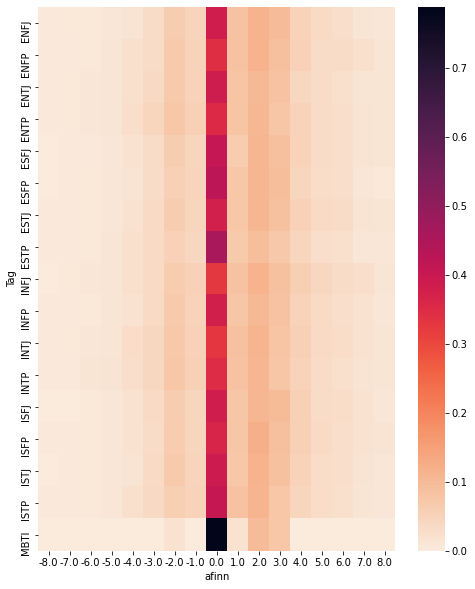

In [62]:
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

fig, ax = pyplot.subplots(figsize=(8,10))
sns.heatmap(crosstab_div, cmap = "rocket_r", ax=ax, annot= False)

### Analysis by sub-category

In [88]:
def change_tags(text):
    subtype = "Untagged"
    if text in ['INTJ', 'INTP', 'ENTJ', 'ENTP']:
        subtype = "Analyst"
    if text in ['INFJ', 'INFP', 'ENFJ', 'ENFP']:
        subtype = "Diplomat"
    if text in ['ISTJ', 'ISFJ', 'ESTJ', 'ESFJ']:
        subtype = "Sentinel"
    if text in ['ISTP', 'ISFP', 'ESTP', 'ESFP']:
        subtype = "Explorer"
    return subtype
        


In [89]:
mbti_revised['Subtype'] = mbti_revised['Tag'].apply(lambda x: change_tags(x))

In [90]:
mbti_revised

,Unnamed: 0,Tag,Cleaned_Text,Cleaned_Text_No_Emoticon,Text_Stemmed,Bigram,afinn,Subtype
0,0,INFP,meme <3,meme,meme,meme,0.0,Diplomat
1,1,ENFJ,memeincorrect quote sure trying keep peace family,memeincorrect quote sure trying keep peace family,memeincorrect quot sure tri peac famili,memeincorrect quote sure trying keep peace family,2.0,Diplomat
2,2,INTP,memeenfp avatar,memeenfp avatar,memeenfp avatar,memeenfp avatar,0.0,Analyst
3,3,ENTP,memefour distinct flavors nt,memefour distinct flavors nt,memefour distinct flavor,memefour distinct flavors nt,0.0,Analyst
4,4,INTJ,stereotypesinfp,stereotypesinfp,stereotypesinfp,stereotypesinfp,0.0,Analyst
...,...,...,...,...,...,...,...,...
137965,137965,ENTJ,correct grammar cant die definition defined usage :) one uses piece grammar stops correct,correct grammar cant die definition defined usage one uses piece grammar stops correct,correct grammar definit defin usag use piec grammar stop correct,correct grammar cant die definition defined usage one uses piece grammar stops correct,-4.0,Analyst
137966,137966,ENTJ,believe youre referring linguistic drift,believe youre referring linguistic drift,believ your refer linguist drift,believe youre_referring linguistic drift,0.0,Analyst
137967,137967,ENTJ,got instead,got instead,instead,got instead,0.0,Analyst
137968,137968,ENTJ,promise always deliver,promise always deliver,promis deliv,promise always deliver,1.0,Analyst


In [91]:
crosstab = pd.crosstab(mbti_revised.Subtype, mbti_revised.afinn)
crosstab_div = crosstab.div(crosstab.sum(axis=1), axis=0)
crosstab

afinn,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
Subtype,,,,,,,,,,,,,,,,,
Analyst,295,336,591,789,1370,2148,3807,2858,18097,4345,5637,4109,2656,1692,1320,891,705
Diplomat,118,197,301,433,743,1197,2315,1759,12152,2846,3886,3059,1871,1238,1014,743,469
Explorer,83,98,167,245,433,747,1294,1019,8892,1677,2405,1795,1032,661,545,322,252
Sentinel,66,84,153,222,405,734,1357,972,8281,1569,2341,1945,1123,697,610,382,271
Untagged,0,0,0,0,0,0,1,0,41,1,5,4,0,0,0,0,0


<AxesSubplot:xlabel='afinn', ylabel='Subtype'>

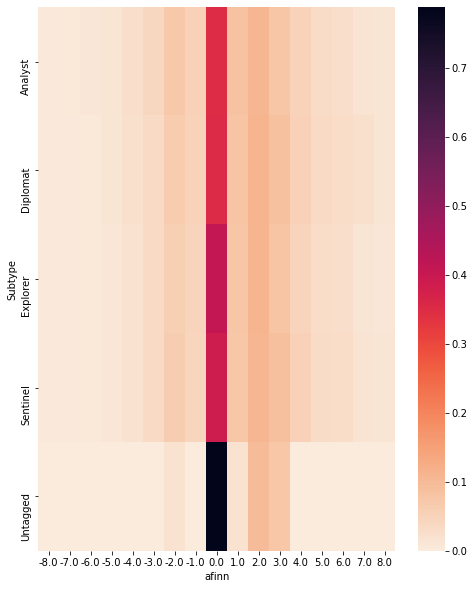

In [92]:
fig, ax = pyplot.subplots(figsize=(8,10))
sns.heatmap(crosstab_div, cmap = "rocket_r", ax=ax, annot= False)

### KMeans Clustering

In [103]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(mbti_revised["Text_Stemmed"].astype(str))

In [104]:
word_features = vectorizer.get_feature_names()


In [105]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, n_init = 5, n_jobs = -1)
kmeans.fit(X)


C:\Users\valli\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=4, n_init=5, n_jobs=-1)

In [106]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))

0 : nan, germophobeenfp, germar, germfreak, germfreeth, germi, germn, germo, germophob, zzzzzzzz
1 : love, time, good, that, work, need, want, intj, entp, intp
2 : like, dont, think, peopl, know, feel, thing, want, time, type
3 : thank, share, love, help, appreci, great, good, need, like, know


In [107]:
mbti_revised['cluster'] = kmeans.labels_

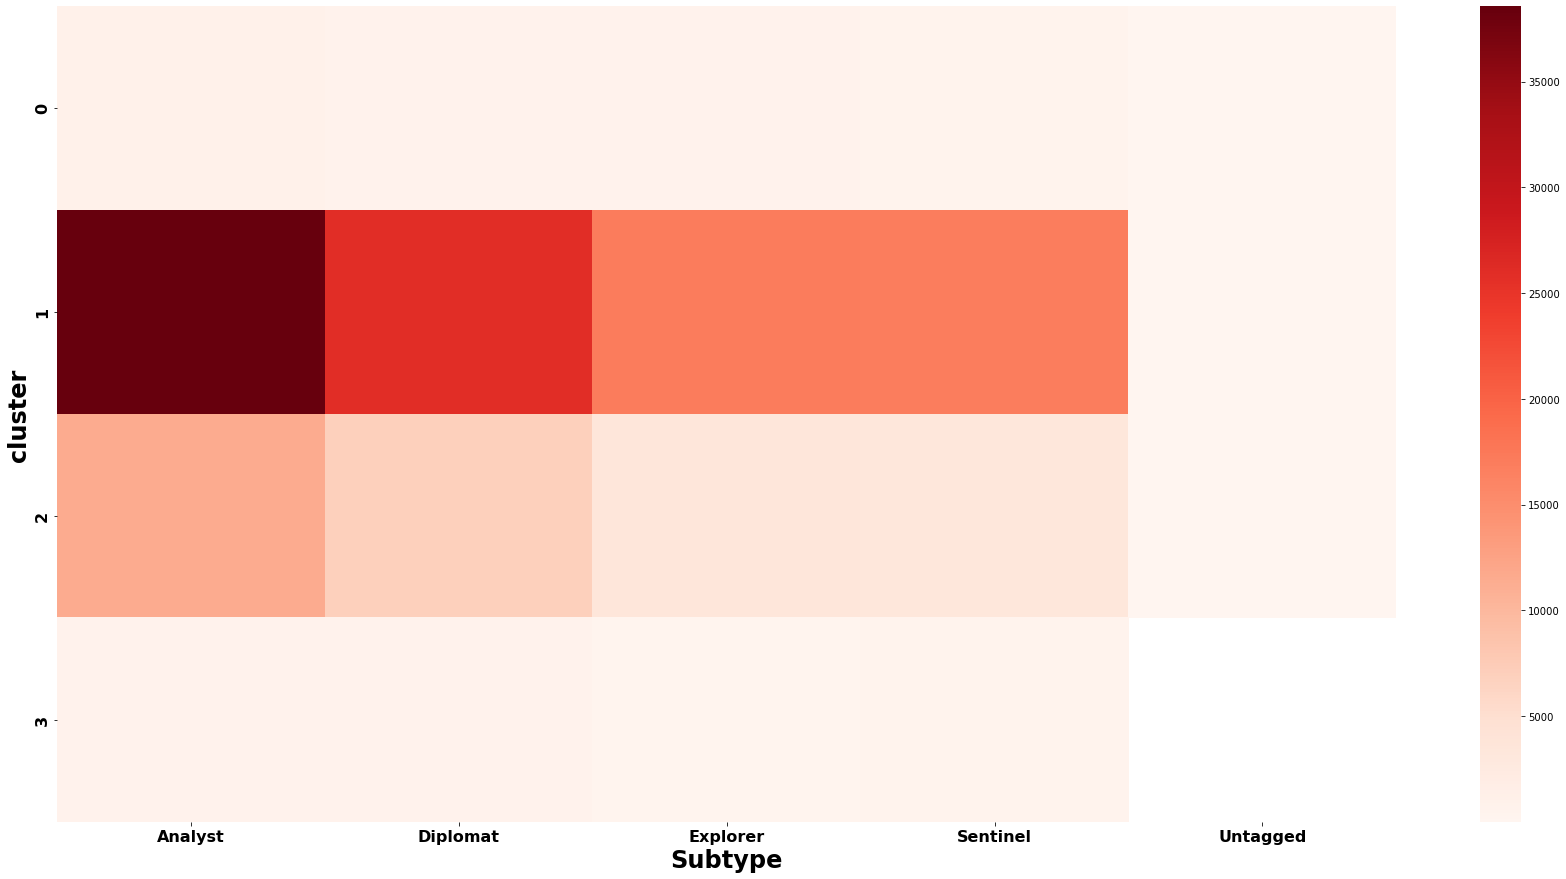

In [109]:
clusters = mbti_revised.groupby(['cluster', 'Subtype']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'Subtype'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('Subtype', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

In [110]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, n_init = 5, n_jobs = -1)
kmeans.fit(X)


C:\Users\valli\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=2, n_init=5, n_jobs=-1)

In [111]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))

0 : like, think, dont, peopl, know, feel, time, thing, love, thank
1 : nan, germophobeenfp, germar, germfreak, germfreeth, germi, germn, germo, germophob, zzzzzzzz


In [112]:
mbti_revised['cluster2'] = kmeans.labels_

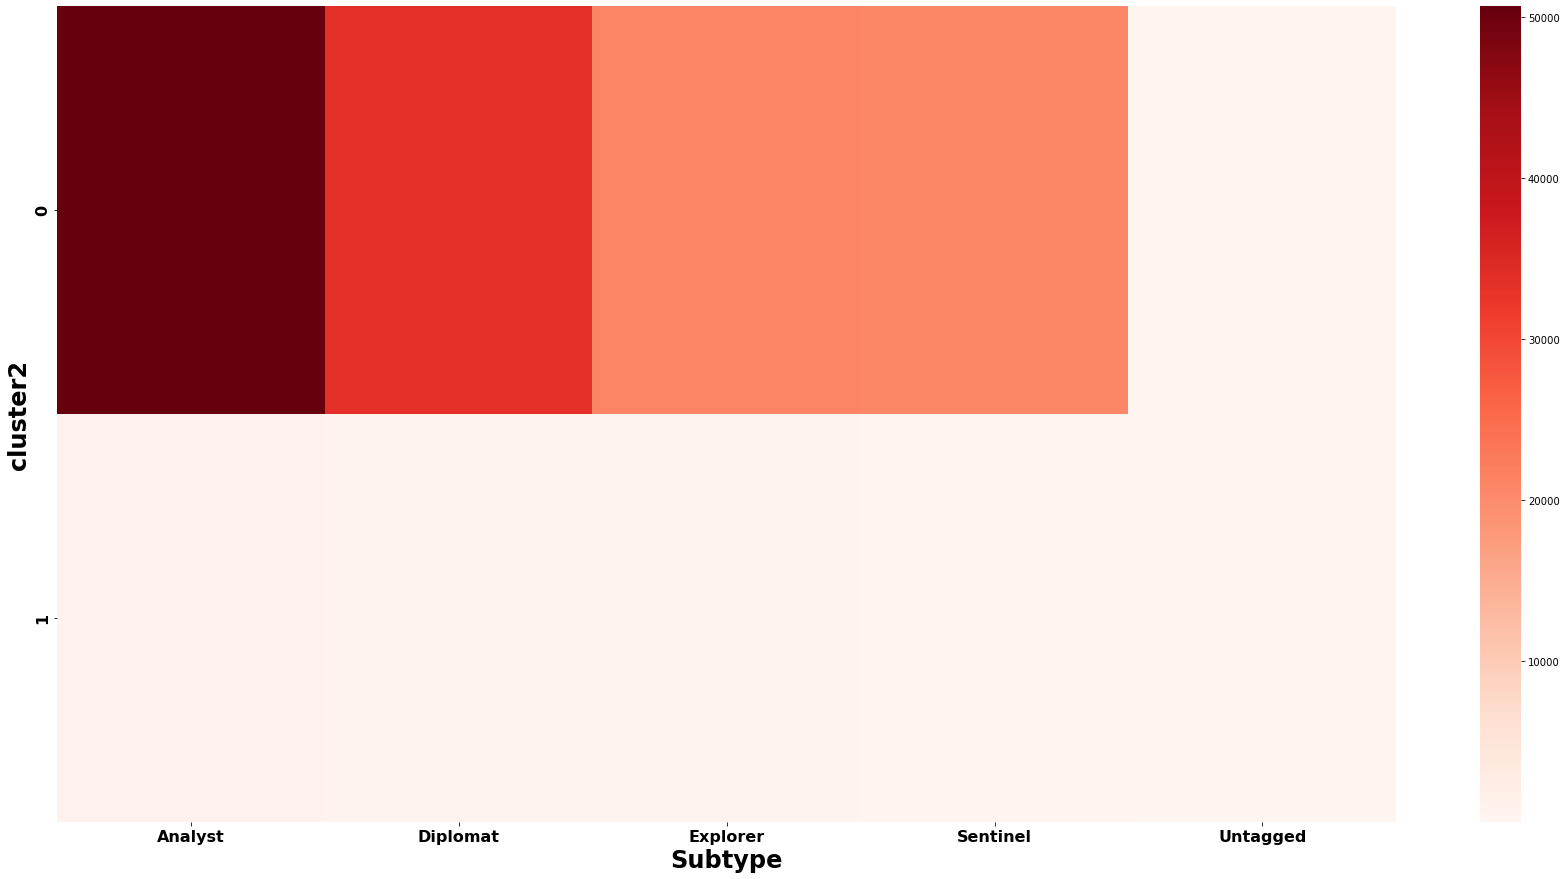

In [113]:
clusters = mbti_revised.groupby(['cluster2', 'Subtype']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'Subtype'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('Subtype', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster2', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

### TextBlob for Polarity and Sentiment

In [115]:
!pip install textblob

  Using cached textblob-0.15.3-py2.py3-none-any.whl (636 kB)


In [116]:
from textblob import TextBlob


In [119]:
def detect_sentiment(text):

    blob = TextBlob(text)
    return blob.sentiment.polarity

In [122]:
mbti_revised['sentiment'] = mbti_revised.Cleaned_Text.astype(str).apply(detect_sentiment)

<AxesSubplot:title={'center':'sentiment'}, xlabel='Subtype'>

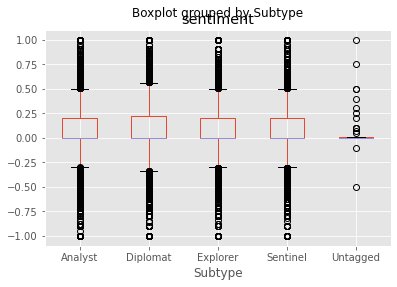

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mbti_revised.boxplot('sentiment', by='Subtype')

In [129]:
mbti_revised.loc[mbti_revised.sentiment == 1, 'Cleaned_Text'].head()

0      meme <3                                                                   
17     personality testsakinorva best                                            
105    memeyall deserve <3                                                       
317    theory questionwhich mbti types work best school intp type team team 2 3 4
613    awesome people help type                                                  
Name: Cleaned_Text, dtype: object

In [130]:
mbti_revised.loc[mbti_revised.sentiment == -1, 'Cleaned_Text'].head()

63      memei found incorrect quote generator put mbtis thought fricking hysterical pt 1
318     theory questionwhy people see enfjs manipulative horrible                       
615     moment shine guys please convince world isnt terrible place                     
911     anyone else terrible coming gifts people                                        
1716    soooo whats evil talent                                                         
Name: Cleaned_Text, dtype: object

### Topic Modelling

In [148]:
corpus = mbti['Text_Stemmed'].str.split().dropna()

In [147]:
type(corpus)

pandas.core.series.Series

In [149]:
dictionary = gensim.corpora.Dictionary(corpus)

In [151]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]
bow_corpus[4310]

[(53, 1), (71, 1), (269, 1)]

In [152]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 1.0)]


In [155]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=2, workers=2)

In [156]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.034*"peopl" + 0.017*"dont" + 0.012*"think" + 0.011*"need" + 0.011*"good" + 0.009*"help" + 0.009*"thing" + 0.009*"know" + 0.008*"point" + 0.008*"mayb"
Topic: 1 
Words: 0.040*"like" + 0.023*"feel" + 0.017*"type" + 0.017*"know" + 0.016*"friend" + 0.014*"dont" + 0.014*"person" + 0.014*"love" + 0.013*"think" + 0.011*"want"
Topic: 2 
Words: 0.024*"time" + 0.022*"thing" + 0.020*"think" + 0.013*"work" + 0.009*"peopl" + 0.009*"dont" + 0.009*"care" + 0.008*"learn" + 0.007*"like" + 0.007*"year"
Topic: 3 
Words: 0.025*"like" + 0.015*"iaeurtmm" + 0.015*"thank" + 0.009*"itaeurtm" + 0.008*"happi" + 0.008*"post" + 0.008*"look" + 0.007*"donaeurtmt" + 0.006*"sure" + 0.005*"nice"


### Swarm Plot - Tag vs Word Count

In [7]:
data = pd.read_csv("MBTI.csv")

In [8]:
data

,Unnamed: 0,Tag,Cleaned_Text,Cleaned_Text_No_Emoticon,Text_stemmed,Bigram,Reddit,Twitter,Typology,Kaggle
0,0,ENFJ,memeincorrect quote sure trying keep peace family,memeincorrect quote sure trying keep peace family,memeincorrect quot sure tri peac famili,memeincorrect quote sure trying keep_peace family,1,0,0,0
1,1,ENTP,memefour distinct flavors nt,memefour distinct flavors nt,memefour distinct flavor,memefour distinct flavors nt,1,0,0,0
2,2,ENTP,memethis definitely intp looks like,memethis definitely intp looks like,memethi definit intp look like,memethis definitely intp looks_like,1,0,0,0
3,3,ISFJ,theory questionwhat type admire,theory questionwhat type admire,theori questionwhat type admir,theory_questionwhat type admire,1,0,0,0
4,4,ISTJ,memeistj x enfp real,memeistj x enfp real,memeistj enfp real,memeistj x enfp real,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
134808,134808,ISFP,always think cats fi doms reason websites beco...,always think cats fi doms reason websites beco...,think cat dom reason websit nazi percim nerd l...,always think cats fi_doms reason websites beco...,0,0,0,1
134809,134809,ENFP,soif thread already exists someplace else heck...,soif thread already exists someplace else heck...,soif thread exist someplac heck delet hereooop...,soif thread already_exists someplace else heck...,0,0,0,1
134810,134810,INTP,many questions things would take purple pill p...,many questions things would take purple pill p...,question thing purpl pill pick win lotteri num...,many questions things would take purple pill p...,0,0,0,1
134811,134811,INFP,conflicted right comes wanting children honest...,conflicted right comes wanting children honest...,conflict right come want children honest mater...,conflicted right comes wanting children honest...,0,0,0,1


In [15]:
def var_row(row):
    l = []
    for i in row.split():
        l.append(len(i.split()))
    return np.var(l)

df = data.copy()[['Tag', "Cleaned_Text_No_Emoticon"]]

df['words_per_comment'] = df['Cleaned_Text_No_Emoticon'].apply(lambda x: len(x.split())/10)
df['variance_of_word_counts'] = df['Cleaned_Text_No_Emoticon'].apply(lambda x: var_row(x))
df.head()

C:\Users\valli\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,Tag,Cleaned_Text_No_Emoticon,words_per_comment,variance_of_word_counts
0,ENFJ,memeincorrect quote sure trying keep peace family,0.7,0.0
1,ENTP,memefour distinct flavors nt,0.4,0.0
2,ENTP,memethis definitely intp looks like,0.5,0.0
3,ISFJ,theory questionwhat type admire,0.4,0.0
4,ISTJ,memeistj x enfp real,0.4,0.0


C:\Users\valli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\valli\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 94.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

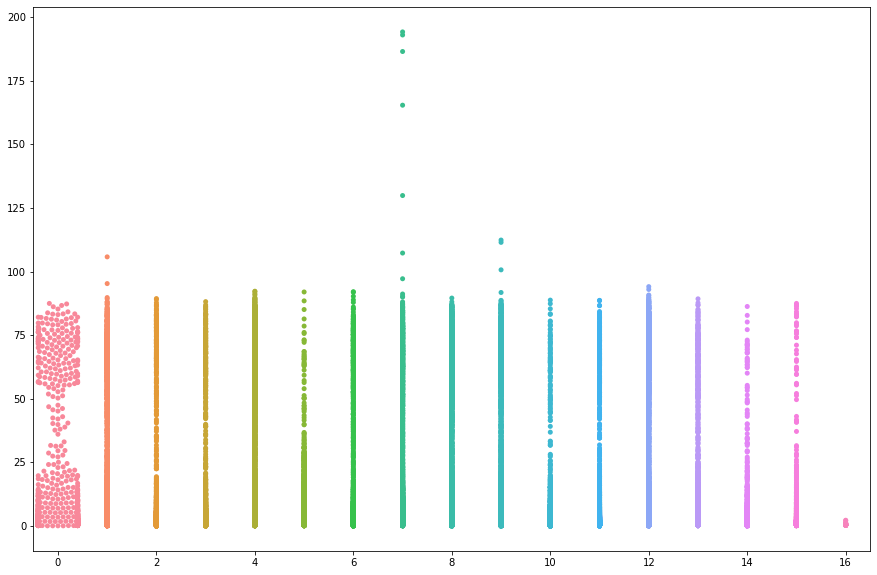

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.swarmplot("Tag", "words_per_comment", data=df)